# Chapter 6 - Notes

## Set Up

### Packages

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr
from scipy import stats
from scipy.special import expit, logit, logsumexp, softmax
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [3]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
CHIMPANZEES_FILE = "chimpanzees.csv"
ADMISSIONS_FILE = "ucbadmit.csv"
KLINE_FILE = "kline.csv"
REEDFROGS_FILE = "reedfrogs.csv"
CARS_FILE = "cars.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

Set seed

In [5]:
rng = np.random.default_rng(RANDOM_SEED)

## 6.1 Multicollinearity

### 6.1.1 Multicollinear legs

Simulate data with colinear predictors

In [6]:
N = 100

rng = np.random.default_rng(RANDOM_SEED)

height = rng.normal(loc=10, scale=2, size=N)
leg_prop = rng.uniform(low=0.4, high=0.5, size=N)
leg_left = leg_prop * height + rng.normal(loc=0, scale=0.02, size=N)
leg_right = leg_prop * height + rng.normal(loc=0, scale=0.02, size=N)

legs = pd.DataFrame(
    {
        "height": height,
        "leg_left": leg_left,
        "leg_right": leg_right,
    }
)

Now fit a model with both predictors

In [7]:
coords = {
    "obs_id": legs.index,
}
with pm.Model(coords_mutable=coords) as m6_1:
    # data
    leg_left = pm.MutableData("leg_left", legs.leg_left, dims="obs_id")
    leg_right = pm.MutableData("leg_right", legs.leg_right, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=10, sigma=100)
    beta_l = pm.Normal("beta_l", mu=2, sigma=10)
    beta_r = pm.Normal("beta_r", mu=2, sigma=10)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu", alpha + beta_l * leg_left + beta_r * leg_right, dims="obs_id"
    )

    # likelihood
    height = pm.Normal(
        "height", mu=mu, sigma=sigma, observed=legs.height, dims="obs_id"
    )

    # fit
    trace_6_1 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_l, beta_r, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


Look at the results

In [8]:
az.summary(
    trace_6_1,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,1.841,0.329,1.309,2.353
beta_l,1.794,1.977,-1.554,4.782
beta_r,0.011,1.973,-3.021,3.284
sigma,0.577,0.042,0.513,0.645


Note the extremely high standard deviation in the coefficients.

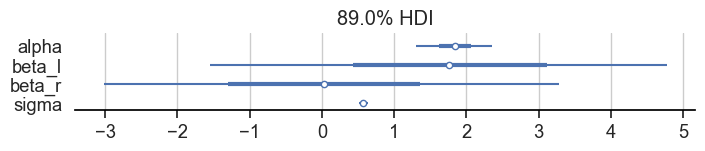

In [9]:
fig, ax = plt.subplots(figsize=(8, 1))

az.plot_forest(
    trace_6_1,
    var_names=["~mu"],
    combined=True,
    hdi_prob=0.89,
    ax=ax,
);

We can see more clearly what is going on by plotting the bivariate distribution of the coefficients and their sum.

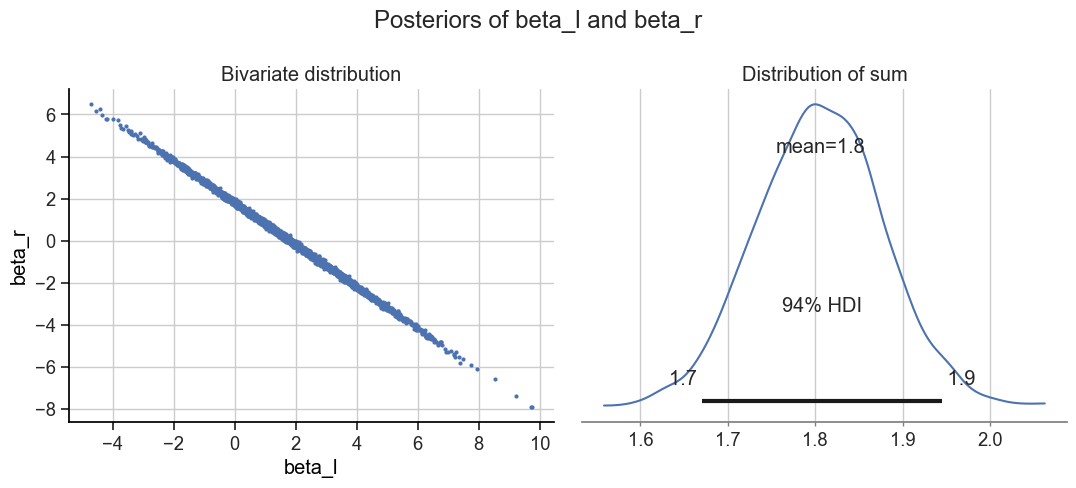

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(11, 5))

az.plot_pair(
    trace_6_1,
    var_names=["beta_l", "beta_r"],
    filter_vars="regex",
    # ax=np.array([axs[:1]]),
    ax=axs[0],
)

trace_6_1.posterior["beta_sum"] = (
    trace_6_1.posterior.beta_l + trace_6_1.posterior.beta_r
)
az.plot_posterior(
    trace_6_1,
    var_names="beta_sum",
    ax=axs[1],
)

axs[0].set(
    title="Bivariate distribution",
)
axs[1].set(
    title="Distribution of sum",
)

fig.suptitle("Posteriors of beta_l and beta_r")
fig.tight_layout();

Now fit a model on just left leg lengths.

In [11]:
coords = {
    "obs_id": legs.index,
}
with pm.Model(coords_mutable=coords) as m6_2:
    # data
    leg_left = pm.MutableData("leg_left", legs.leg_left, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=10, sigma=100)
    beta_l = pm.Normal("beta_l", mu=2, sigma=10)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", alpha + beta_l * leg_left, dims="obs_id")

    # likelihood
    height = pm.Normal(
        "height", mu=mu, sigma=sigma, observed=legs.height, dims="obs_id"
    )

    # fit
    trace_6_2 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_l, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Look at the results

In [12]:
az.summary(
    trace_6_2,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,1.840,0.327,1.303,2.333
beta_l,1.806,0.072,1.694,1.920
sigma,0.575,0.041,0.509,0.637


That looks much more reasonable.

### 6.1.2 Multicollinear milk

Load the milk data

In [13]:
# load data
milk = load_data(MILK_FILE, delimiter=";")

# rename variables
milk.columns = milk.columns.str.replace(".", "_")

# standardise variables
cols = ["kcal_per_g", "perc_fat", "perc_lactose"]
milk_normaliser = StandardScaler()
milk_normaliser.fit(milk[cols])

milk_norm = pd.DataFrame(
    data=milk_normaliser.transform(milk[cols]),
    columns=cols,
)

Start with two univariate models

In [14]:
coords = {
    "obs_id": milk_norm.index,
}
with pm.Model(coords_mutable=coords) as m6_3:
    # data
    perc_fat = pm.MutableData("perc_fat", milk_norm.perc_fat, dims="obs_id")
    perc_lactose = pm.MutableData("perc_lactose", milk_norm.perc_lactose, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_f = pm.Normal("beta_f", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", alpha + beta_f * perc_fat, dims="obs_id")

    # likelihood
    kcal_per_g = pm.Normal(
        "kcal_per_g", mu=mu, sigma=sigma, observed=milk_norm.kcal_per_g, dims="obs_id"
    )

    # sample
    trace_6_3 = pm.sample(random_seed=RANDOM_SEED)


with pm.Model(coords_mutable=coords) as m6_4:
    # data
    perc_fat = pm.MutableData("perc_fat", milk_norm.perc_fat, dims="obs_id")
    perc_lactose = pm.MutableData("perc_lactose", milk_norm.perc_lactose, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_l = pm.Normal("beta_l", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", alpha + beta_l * perc_lactose, dims="obs_id")

    # likelihood
    kcal_per_g = pm.Normal(
        "kcal_per_g", mu=mu, sigma=sigma, observed=milk_norm.kcal_per_g, dims="obs_id"
    )

    # sample
    trace_6_4 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_f, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_l, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Look at the posteriors

In [15]:
pm.summary(
    trace_6_3,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,-0.00,0.08,-0.13,0.13
beta_f,0.86,0.09,0.71,1.00
sigma,0.50,0.07,0.39,0.60


In [16]:
pm.summary(
    trace_6_4,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,0.00,0.07,-0.11,0.12
beta_l,-0.90,0.08,-1.02,-0.78
sigma,0.42,0.06,0.33,0.51


Note that the two coefficients appear to be opposites.

Now fit a model with both predictors.

In [17]:
coords = {
    "obs_id": milk_norm.index,
}
with pm.Model(coords_mutable=coords) as m6_5:
    # data
    perc_fat = pm.MutableData("perc_fat", milk_norm.perc_fat, dims="obs_id")
    perc_lactose = pm.MutableData("perc_lactose", milk_norm.perc_lactose, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_f = pm.Normal("beta_f", mu=0, sigma=0.5)
    beta_l = pm.Normal("beta_l", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu", alpha + beta_f * perc_fat + beta_l * perc_lactose, dims="obs_id"
    )

    # likelihood
    kcal_per_g = pm.Normal(
        "kcal_per_g", mu=mu, sigma=sigma, observed=milk_norm.kcal_per_g, dims="obs_id"
    )

    # sample
    trace_6_5 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_f, beta_l, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [18]:
pm.summary(
    trace_6_5,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,0.00,0.07,-0.11,0.13
beta_f,0.25,0.20,-0.05,0.58
beta_l,-0.67,0.20,-0.98,-0.34
sigma,0.42,0.06,0.33,0.51


We can understand what's happening by plotting the associations between the different variables

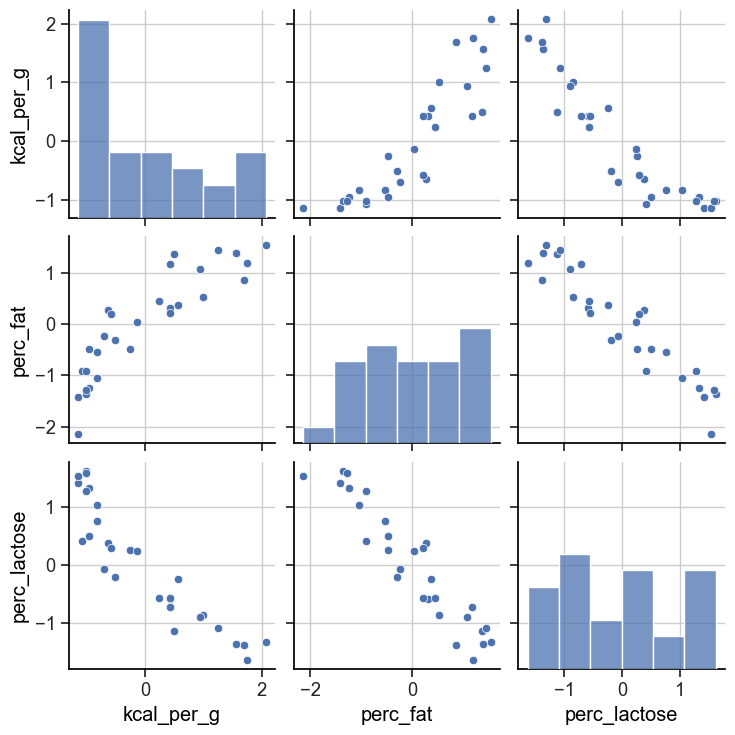

In [19]:
sns.pairplot(milk_norm);

The two predictors are strongly correlated with each other, but also strongly correlated with the target variable.